# King County House Prices – Complete EDA

# Dataset Dictionary

The dataset cantains 20 house features plus the price, along with 21613 observations.

The description for the 20 features is given below:

 - id: A unique identifier for a house.
 - date: The date on which the house was sold.
 - price: The sale price of the house (prediction target).
 - bedrooms: Number of bedrooms in the house.
 - bathrooms: Number of bathrooms in the house, per bedroom.
 - sqft_living: Square footage of the interior living space.
 - sqft_lot: Square footage of the land space.
 - floors: Number of floors (levels) in the house.
 - waterfront: Whether the house has a waterfront view.
 - view: Number of times the house has been viewed.
 - condition: The overall condition of the house.
 - grade: The overall grade given to the house, based on the King County grading system.
 - sqft_above: Square footage of the house apart from the basement.
 - sqft_basement: Square footage of the basement.
 - yr_built: The year the house was built.
 - yr_renovated: The year the house was renovated.
 - zipcode: ZIP code area.
 - lat: Latitude coordinate.
 - long: Longitude coordinate.
 - sqft_living15: The interior living space for the nearest 15 neighbors in 2015.
 - sqft_lot15: The land spaces for the nearest 15 neighbors in 2015.
 - price: The sale price of the house (target variable).

dataset source: [Kaggle - King County House Sales](https://www.kaggle.com/datasets/minasameh55/king-country-houses-aa)


In [47]:
# =====================================================================
# 0. Initial setup
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
import os

sns.set_palette("viridis")

RANDOM_STATE = 42

In [48]:
# ========================================
# GLOBAL DARK/VIRIDIS STYLE
# ========================================
# Sets the global theme and palette for all subsequent plots
sns.set_theme(style="dark", palette="viridis", font_scale=1.1)

# Updates matplotlib rcParams with custom dark theme settings
plt.rcParams.update({
    'figure.figsize': (12, 7),           # Default figure size
    'figure.facecolor': '#212529',        # Dark figure background
    'axes.facecolor': '#212529',          # Dark axes background
    'axes.edgecolor': 'grey',             # Grey axes border
    'axes.labelcolor': 'grey',            # X/Y axis labels color
    'text.color': 'grey',                 # Titles, legends, all text color
    'xtick.color': 'grey',                # X-axis tick color
    'ytick.color': 'grey',                # Y-axis tick color
    'axes.spines.top': False,             # Remove top spine
    'axes.spines.right': False,           # Remove right spine
    'axes.grid': False,                   # No grid lines
    'font.size': 12,                      # Default font size
    'xtick.labelsize': 11,                # X-tick label size
    'ytick.labelsize': 11,                # Y-tick label size
    'patch.edgecolor': 'none',            # ← FIXED: No white edges on bars
    'patch.linewidth': 0                  # ← FIXED: Zero bar outline
})

# Global color palette (your viridis preference)
colors = sns.color_palette("viridis", n_colors=10)
# print if code runs successfully without conflicts
print("✅ Dark/Viridis global style loaded!")
print("📊 All plots will now use this style automatically.")


def dark_plot(plot_func, *args, **kwargs):
    """
    Minimalist white styling:
    - Single color for all bars/points
    - Clean and simple
    - Blue to orange gradient only when multiple categories needed
    """
    ax = plot_func(*args, **kwargs)
    
    # Simple color palette: blue to orange
    simple_colors = ['#4A90E2', '#5FA3E8', '#7AB8ED', '#95CDF2', 
                     '#F39C12', '#E67E22', '#D35400', '#BA4A00']
    
    # --- BARS / HISTOGRAMS (Rectangles) ---
    if ax.patches:
        # Check if multiple groups or single histogram
        n_patches = len(ax.patches)
        
        if n_patches <= 20:  # Likely a grouped bar chart
            for i, patch in enumerate(ax.patches):
                patch.set_facecolor(simple_colors[i % len(simple_colors)])
                patch.set_edgecolor('none')
                patch.set_alpha(0.8)
        else:  # Single histogram with many bars
            for patch in ax.patches:
                patch.set_facecolor('#4A90E2')  # Single blue
                patch.set_edgecolor('none')
                patch.set_alpha(0.8)
    
    # --- SCATTER (PathCollections) ---
    for coll in ax.collections:
        name = str(type(coll)).lower()
        if "pathcollection" in name:
            coll.set_facecolor('#4A90E2')  # Single blue
            coll.set_edgecolor('none')
            coll.set_alpha(0.6)
    
    # --- LINES (KDE, lineplot, etc.) ---
    for line in ax.lines:
        line.set_color('#4A90E2')  # Single blue
        line.set_linewidth(2)
        line.set_alpha(0.8)
    
    # --- BOXPLOT ---
    # boxes
    for artist in ax.artists:
        artist.set_edgecolor('#4A90E2')
        artist.set_linewidth(1.5)
        artist.set_facecolor('none')  # No fill, just outline
    
    # whiskers, caps, medians
    if "boxplot" in str(plot_func):
        for line in ax.lines:
            line.set_color('#4A90E2')
            line.set_linewidth(1.5)
    
    # outliers
    for coll in ax.collections:
        name = str(type(coll)).lower()
        if "pathcollection" in name and "box" in str(plot_func):
            coll.set_facecolor('#F39C12')  # Orange for outliers
            coll.set_edgecolor('none')
            coll.set_alpha(0.7)
    
    # Clean white background
    ax.set_facecolor('white')
    ax.figure.patch.set_facecolor('white')
    
    # Minimal grid
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, color='#E0E0E0')
    
    # Clean spines
    for spine in ax.spines.values():
        spine.set_edgecolor('#D0D0D0')
        spine.set_linewidth(1)
    
    # Simple ticks and labels
    ax.tick_params(colors='#666666', which='both')
    ax.xaxis.label.set_color('#333333')
    ax.yaxis.label.set_color('#333333')
    ax.title.set_color('#333333')
    
    return ax

✅ Dark/Viridis global style loaded!
📊 All plots will now use this style automatically.


---

## 1. Introduction

Goal of this notebook:

- Explore the King County (WA, USA) house sales dataset.
- Understand the distribution of each variable and its relationship with the target (`price`).
- Detect data quality issues (outliers, duplicates, inconsistencies).
- Prepare a set of cleaning and feature engineering decisions for a future price prediction model.

Dataset source: [Kaggle - King County House Sales](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)

---

## 2. Loading and initial overview

In [49]:
# =====================================================================
# 2. Load data
# =====================================================================

##### Get the data from Kaggle ###
path = kagglehub.dataset_download("minasameh55/king-country-houses-aa")
# print("Path to dataset files:", path)

# List all files in the downloaded directory
files = os.listdir(path)
# print("Files in dataset:", files)

# Load the CSV file: Get first CSV file
csv_file = [f for f in files if f.endswith('.csv')][0]  
full_path = os.path.join(path, csv_file)
# print(f"Loading file: {full_path}")

df = pd.read_csv(full_path)


df.shape

(21613, 21)

In [50]:
# Quick peek
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [51]:
# Info on dtypes and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [52]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370842e+00,9.300618e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.114757e+00,7.701632e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.409430e+00,6.507430e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


Key points to comment in the report:

- Number of rows and columns (21,613 x 21).
- Available variables:
  - Identifier and time: `id`, `date`
  - Target: `price`
  - Structure: `bedrooms`, `bathrooms`, `sqft_living`, `sqft_lot`, `floors`, `sqft_above`, `sqft_basement`
  - Condition / quality: `condition`, `grade`
  - Age: `yr_built`, `yr_renovated`
  - Location: `zipcode`, `lat`, `long`
  - Neighbourhood context: `sqft_living15`, `sqft_lot15`

Check for missing values:

In [53]:
# Missing values per column
df.isna().sum().sort_values(ascending=False)

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

---

## 3. Data quality

### 3.1. Duplicates

In [54]:
# Fully duplicated rows
df.duplicated().sum()

np.int64(0)

In [55]:
# Duplicate ids (same house may appear more than once)
dup_id_count = df.duplicated(subset=["id"]).sum()
dup_id_count

np.int64(177)

In [56]:
# Inspect some examples with duplicate ids
df[df.duplicated(subset=["id"], keep=False)].sort_values("id").head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2497,1000102,20150422T000000,300000.0,6,3.00,2400,9373,2.0,0,0,...,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316
2496,1000102,20140916T000000,280000.0,6,3.00,2400,9373,2.0,0,0,...,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316
16814,7200179,20141016T000000,150000.0,2,1.00,840,12750,1.0,0,0,...,6,840,0,1925,0,98055,47.4840,-122.211,1480,6969
16815,7200179,20150424T000000,175000.0,2,1.00,840,12750,1.0,0,0,...,6,840,0,1925,0,98055,47.4840,-122.211,1480,6969
11433,109200390,20140820T000000,245000.0,3,1.75,1480,3900,1.0,0,0,...,7,1480,0,1980,0,98023,47.2977,-122.367,1830,6956
11434,109200390,20141020T000000,250000.0,3,1.75,1480,3900,1.0,0,0,...,7,1480,0,1980,0,98023,47.2977,-122.367,1830,6956
12417,123039336,20140611T000000,148000.0,1,1.00,620,8261,1.0,0,0,...,5,620,0,1939,0,98106,47.5138,-122.364,1180,8244
12418,123039336,20141208T000000,244900.0,1,1.00,620,8261,1.0,0,0,...,5,620,0,1939,0,98106,47.5138,-122.364,1180,8244
7792,251300110,20140731T000000,225000.0,3,2.25,2510,12013,2.0,0,0,...,8,2510,0,1988,0,98003,47.3473,-122.314,1870,8017
7793,251300110,20150114T000000,358000.0,3,2.25,2510,12013,2.0,0,0,...,8,2510,0,1988,0,98003,47.3473,-122.314,1870,8017


Discussion:

- There are around 177 duplicated `id`s.
- Check whether duplicates correspond to:
  - the same house sold on different dates (different `date` / `price`), or
  - exact row duplicates.
- Possible decision for modeling:
  - Keep only the **most recent sale** per `id`, or
  - Keep all records if modeling dynamics over time.

In [57]:
# If we decide to keep only the latest sale per 'id'
#df_sorted = df.sort_values(by=["id", "date"])
#df_unique = df_sorted.groupby("id", as_index=False).tail(1).reset_in#dex(drop=True)

#df_unique.shape

---

### 3.2. Extreme / suspicious values

In [58]:
# Distribution of bedrooms and bathrooms
df["bedrooms"].value_counts().sort_index()

bedrooms
0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

In [59]:
df["bathrooms"].value_counts().sort_index()

bathrooms
0.00      10
0.50       4
0.75      72
1.00    3852
1.25       9
1.50    1446
1.75    3048
2.00    1930
2.25    2047
2.50    5380
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: count, dtype: int64

In [60]:
df[["bedrooms", "bathrooms", "sqft_living", "sqft_lot"]].describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,21613.0,3.370842,0.930062,0.0,3.00,3.00,4.0,33.0
bathrooms,21613.0,2.114757,0.770163,0.0,1.75,2.25,2.5,8.0
sqft_living,21613.0,2079.899736,918.440897,290.0,1427.00,1910.00,2550.0,13540.0
sqft_lot,21613.0,15106.967566,41420.511515,520.0,5040.00,7618.00,10688.0,1651359.0


In [61]:
# Suspicious rows: many rooms or zero rooms/bathrooms
suspicious = df[
    (df["bedrooms"] == 0) |
    (df["bathrooms"] == 0) |
    (df["bedrooms"] > 10)
]

suspicious[["id", "price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot"]].head(20)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot
875,6306400140,1095000.0,0,0.00,3064,4764
1149,3421079032,75000.0,1,0.00,670,43377
3119,3918400017,380000.0,0,0.00,1470,979
3467,1453602309,288000.0,0,1.50,1430,1650
4868,6896300380,228000.0,0,1.00,390,5900
5832,5702500050,280000.0,1,0.00,600,24501
6994,2954400190,1295650.0,0,0.00,4810,28008
8477,2569500210,339950.0,0,2.50,2290,8319
8484,2310060040,240000.0,0,2.50,1810,5669
8757,1773100755,520000.0,11,3.00,3000,4960


Observations:

- `bedrooms` ranges from 0 to 33:
  - 0 bedrooms: likely studio/loft cases or data issues.
  - 33 bedrooms: almost certainly an outlier or error.
- `bathrooms` has minimum 0, which is unusual for expensive houses.
- `sqft_lot` and `sqft_lot15` have very long right tails (up to over 1.6M sqft).
- `price` also has strong outliers (up to 7.7M).

In [62]:
# Helper to inspect percentiles:
def percentiles(col):
    return df[col].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1.0])

percentiles("price")

0.00      75000.00
0.01     153500.36
0.05     210000.00
0.25     321950.00
0.50     450000.00
0.75     645000.00
0.95    1156480.00
0.99    1964400.00
1.00    7700000.00
Name: price, dtype: float64

In [63]:
percentiles("sqft_living"), percentiles("sqft_lot")

(0.00      290.0
 0.01      720.0
 0.05      940.0
 0.25     1427.0
 0.50     1910.0
 0.75     2550.0
 0.95     3760.0
 0.99     4978.8
 1.00    13540.0
 Name: sqft_living, dtype: float64,
 0.00        520.00
 0.01       1013.12
 0.05       1800.00
 0.25       5040.00
 0.50       7618.00
 0.75      10688.00
 0.95      43339.20
 0.99     213008.00
 1.00    1651359.00
 Name: sqft_lot, dtype: float64)

This motivates later:

- Winsorization / capping above the 99th percentile for `price` and some area variables, or
- at least checking model performance with and without extreme outliers.

---

## 4. Univariate analysis

### 4.1. Target: `price`

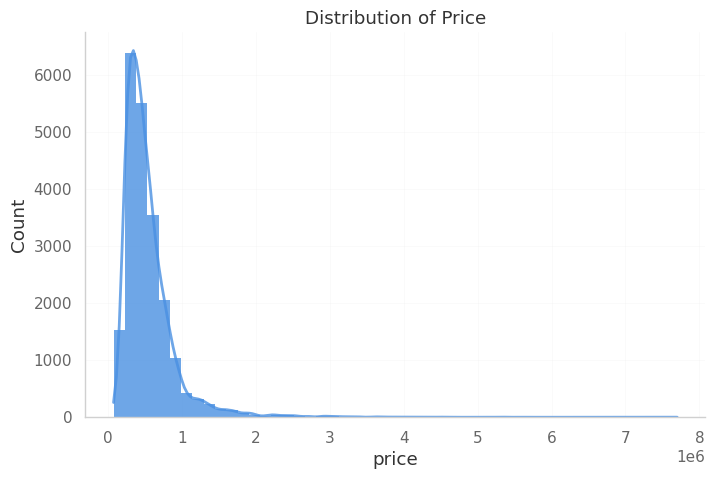

In [64]:
plt.figure(figsize=(8, 5))
dark_plot(sns.histplot, data=df["price"], kde=True, bins=50)
plt.title("Distribution of Price")
plt.show()

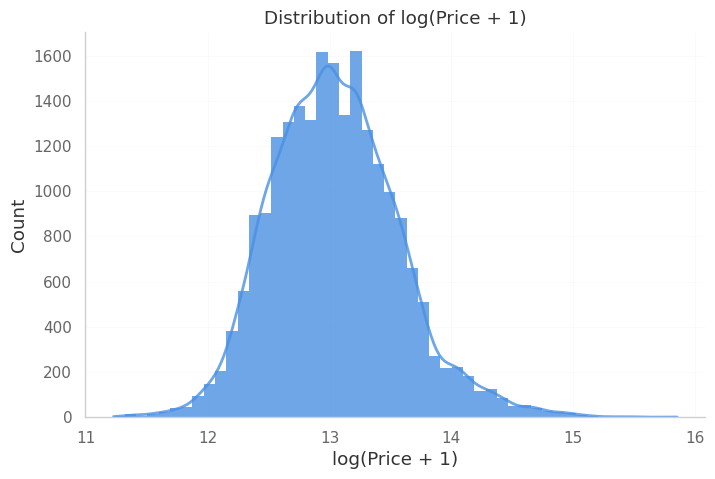

In [65]:
df["log_price"] = np.log1p(df["price"])

plt.figure(figsize=(8, 5))
dark_plot(sns.histplot, data=df["log_price"], kde=True, bins=50)
plt.title("Distribution of log(Price + 1)")
plt.xlabel("log(Price + 1)")
plt.ylabel("Count")
plt.show()

Comments:

- On the original scale, `price` is heavily right-skewed.
- On the log scale, the distribution is closer to normal, which can help linear models.

### 4.2. Main numerical variables

In [66]:
num_cols = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "sqft_above", "sqft_basement",
    "yr_built", "yr_renovated",
    "sqft_living15", "sqft_lot15"
]

df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,21613.0,3.370842,0.930062,0.0,3.00,3.00,4.0,33.0
bathrooms,21613.0,2.114757,0.770163,0.0,1.75,2.25,2.5,8.0
sqft_living,21613.0,2079.899736,918.440897,290.0,1427.00,1910.00,2550.0,13540.0
sqft_lot,21613.0,15106.967566,41420.511515,520.0,5040.00,7618.00,10688.0,1651359.0
floors,21613.0,1.494309,0.539989,1.0,1.00,1.50,2.0,3.5
sqft_above,21613.0,1788.390691,828.090978,290.0,1190.00,1560.00,2210.0,9410.0
sqft_basement,21613.0,291.509045,442.575043,0.0,0.00,0.00,560.0,4820.0
yr_built,21613.0,1971.005136,29.373411,1900.0,1951.00,1975.00,1997.0,2015.0
yr_renovated,21613.0,84.402258,401.679240,0.0,0.00,0.00,0.0,2015.0
sqft_living15,21613.0,1986.552492,685.391304,399.0,1490.00,1840.00,2360.0,6210.0


Optional: histograms grid.

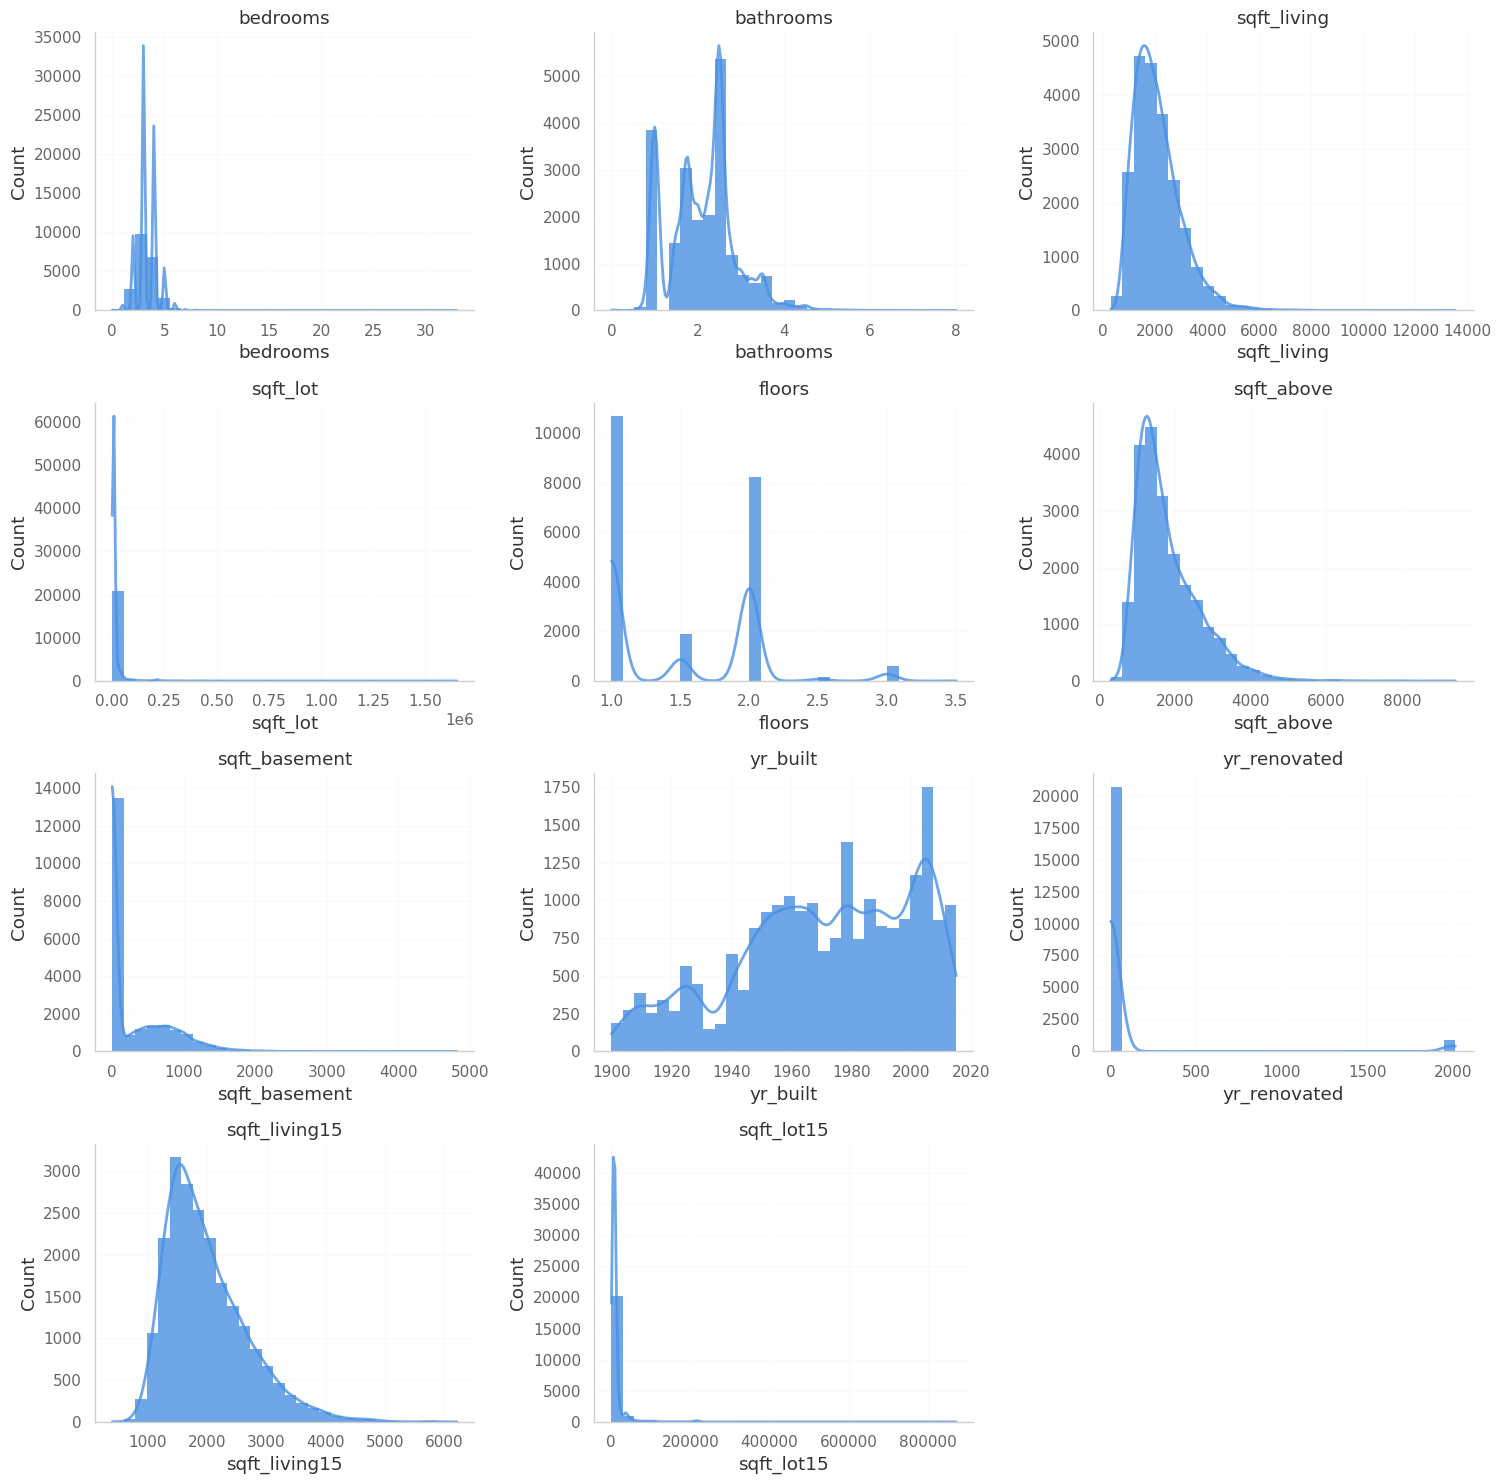

In [67]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    dark_plot(sns.histplot, data=df[col], kde=True, bins=30, ax=ax)
    ax.set_title(col)

# If there are unused subplots
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Key patterns:

- `bedrooms` is concentrated between 2 and 4.
- `bathrooms` mostly between 1 and 3.
- `sqft_living` typically between 1,000 and 3,000 sqft, with a long tail.
- `yr_built` centered around the 1970s; 
- `yr_renovated` is 0 for most homes (never renovated).

### 4.3. Discrete / quasi-categorical variables

In [68]:
cat_cols = ["floors", "waterfront", "view", "condition", "grade", "zipcode"]

for col in cat_cols:
    print(f"\n=== {col} ===")
    print(df[col].value_counts().head(15))


=== floors ===
floors
1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: count, dtype: int64

=== waterfront ===
waterfront
0    21450
1      163
Name: count, dtype: int64

=== view ===
view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64

=== condition ===
condition
3    14031
4     5679
5     1701
2      172
1       30
Name: count, dtype: int64

=== grade ===
grade
7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: count, dtype: int64

=== zipcode ===
zipcode
98103    602
98038    590
98115    583
98052    574
98117    553
98042    548
98034    545
98118    508
98023    499
98006    498
98133    494
98059    468
98058    455
98155    446
98074    441
Name: count, dtype: int64


Bar plots for key discrete variables:

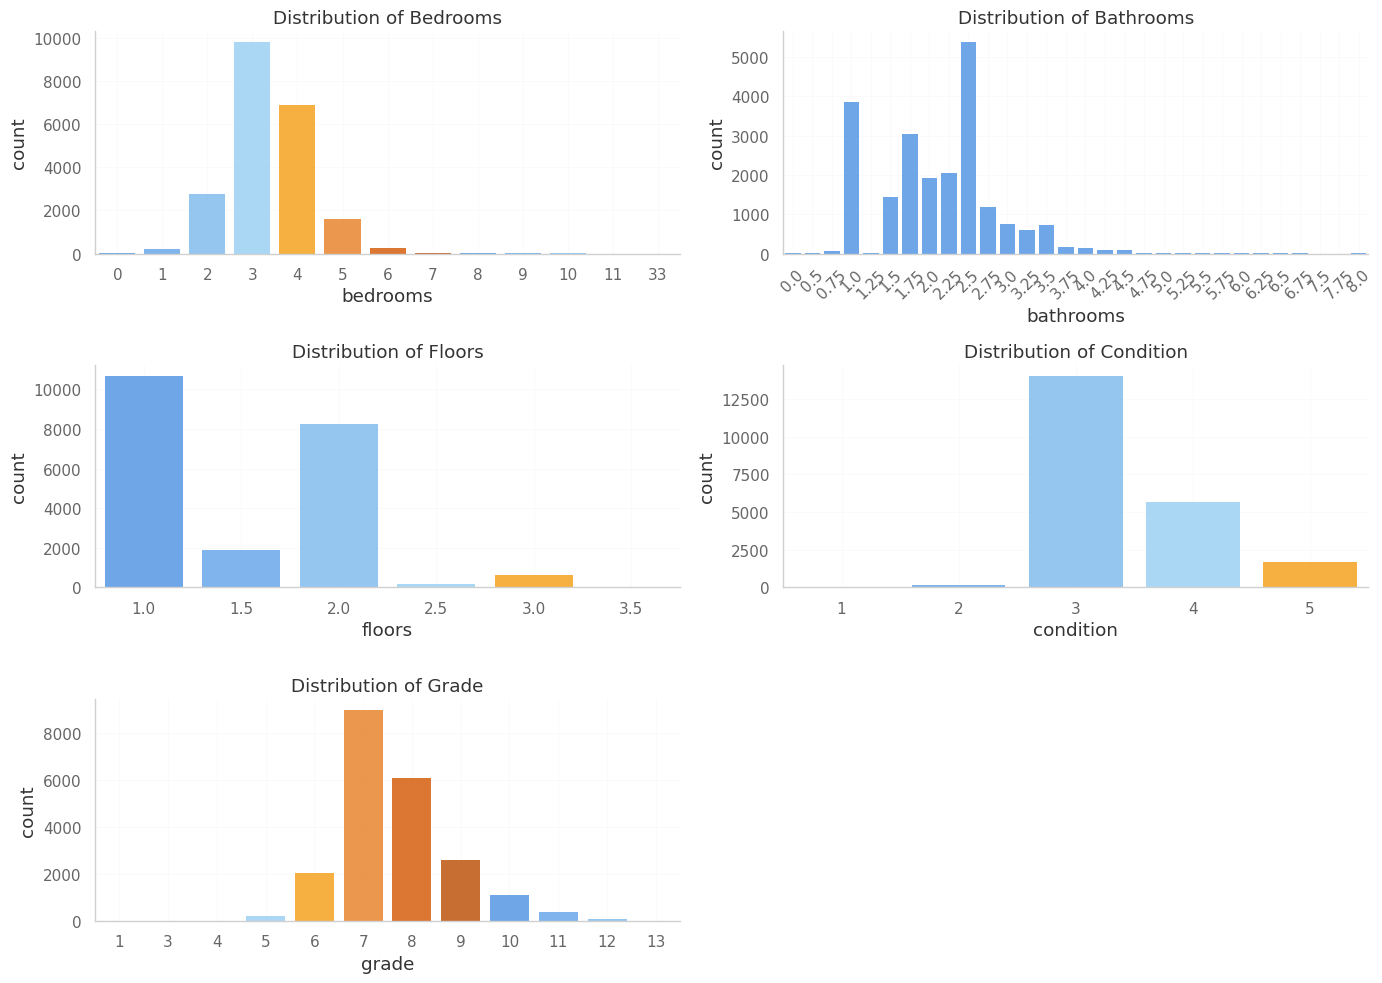

In [69]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# 1) Bedrooms
dark_plot(
    sns.countplot,
    x="bedrooms",
    data=df,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Distribution of Bedrooms")

# 2) Bathrooms
dark_plot(
    sns.countplot,
    x="bathrooms",
    data=df,
    ax=axes[0, 1],
)
axes[0, 1].set_title("Distribution of Bathrooms")
axes[0, 1].tick_params(axis="x", rotation=45)

# 3) Floors
dark_plot(
    sns.countplot,
    x="floors",
    data=df,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Distribution of Floors")

# 4) Condition
dark_plot(
    sns.countplot,
    x="condition",
    data=df,
    ax=axes[1, 1],
)
axes[1, 1].set_title("Distribution of Condition")

# 5) Grade
dark_plot(
    sns.countplot,
    x="grade",
    data=df,
    ax=axes[2, 0],
)
axes[2, 0].set_title("Distribution of Grade")
axes[2, 1].axis("off")
plt.tight_layout()
plt.show()


Insights:

- `waterfront` is almost always 0 (very few waterfront properties).
- `view` is 0 for the majority; higher values (3–4) are rare.
- `condition` is mostly 3–4.
- `grade` is mostly 7–8.

---

## 5. Bivariate analysis with price

### 5.1. Numerical variables vs `price`

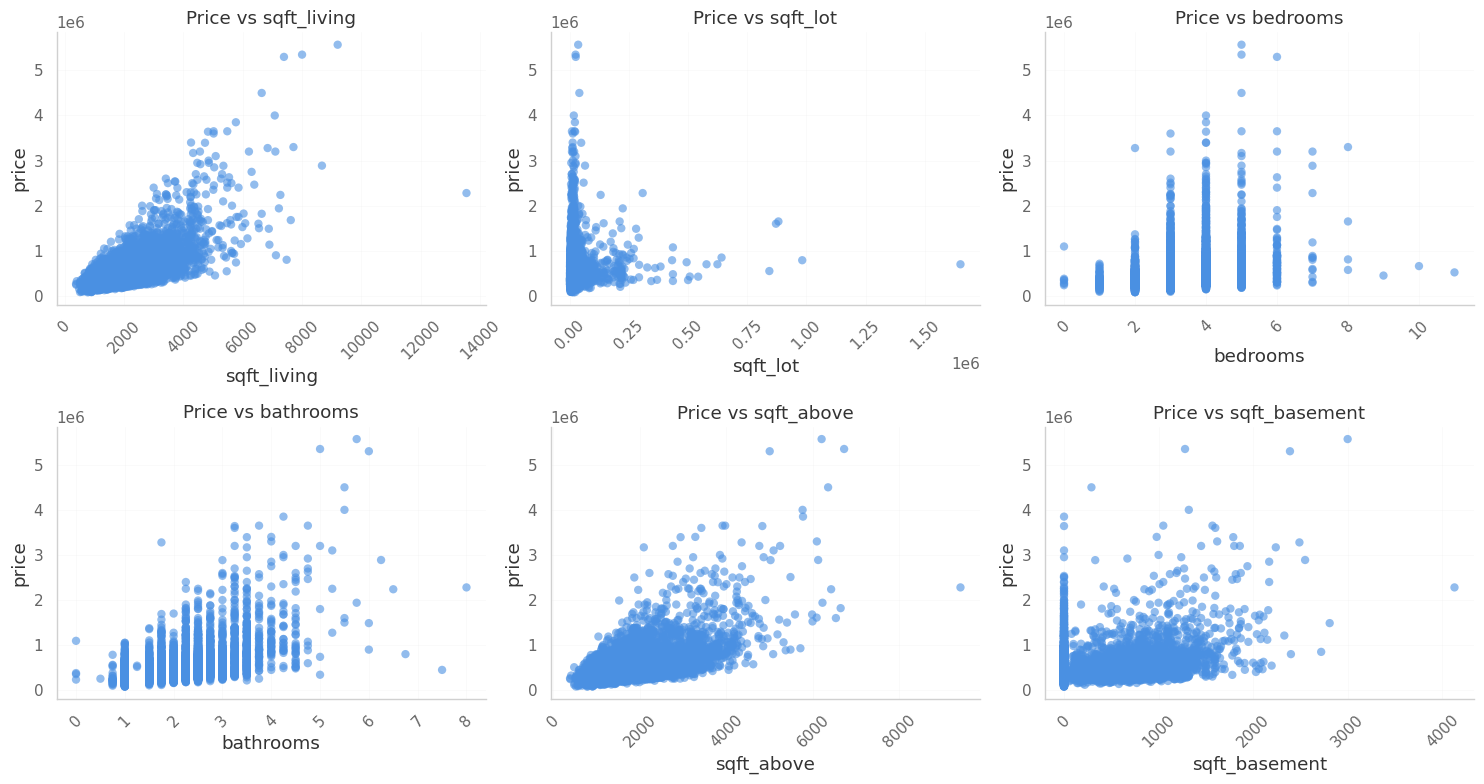

In [70]:
# Helper to sample for lighter scatterplots
cols = ["sqft_living", "sqft_lot", "bedrooms", "bathrooms", "sqft_above", "sqft_basement"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
axes = axes.flatten()

for ax, col in zip(axes, cols):
    data = df.sample(frac=0.3, random_state=RANDOM_STATE)
    
    # Use our dark_plot but pass the target axes
    plt.sca(ax)  # set current axis so dark_plot draws here
    dark_plot(sns.scatterplot, x=col, y="price", data=data)

    ax.set_title(f"Price vs {col}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Comments:

- Strong positive relationship between `sqft_living` and `price`.
- `bathrooms` and `bedrooms` show increasing trend with high dispersion.
- `sqft_lot` is noisier and less clearly related than `sqft_living`.

### 5.2. Discrete / categorical vs `price` (boxplots)

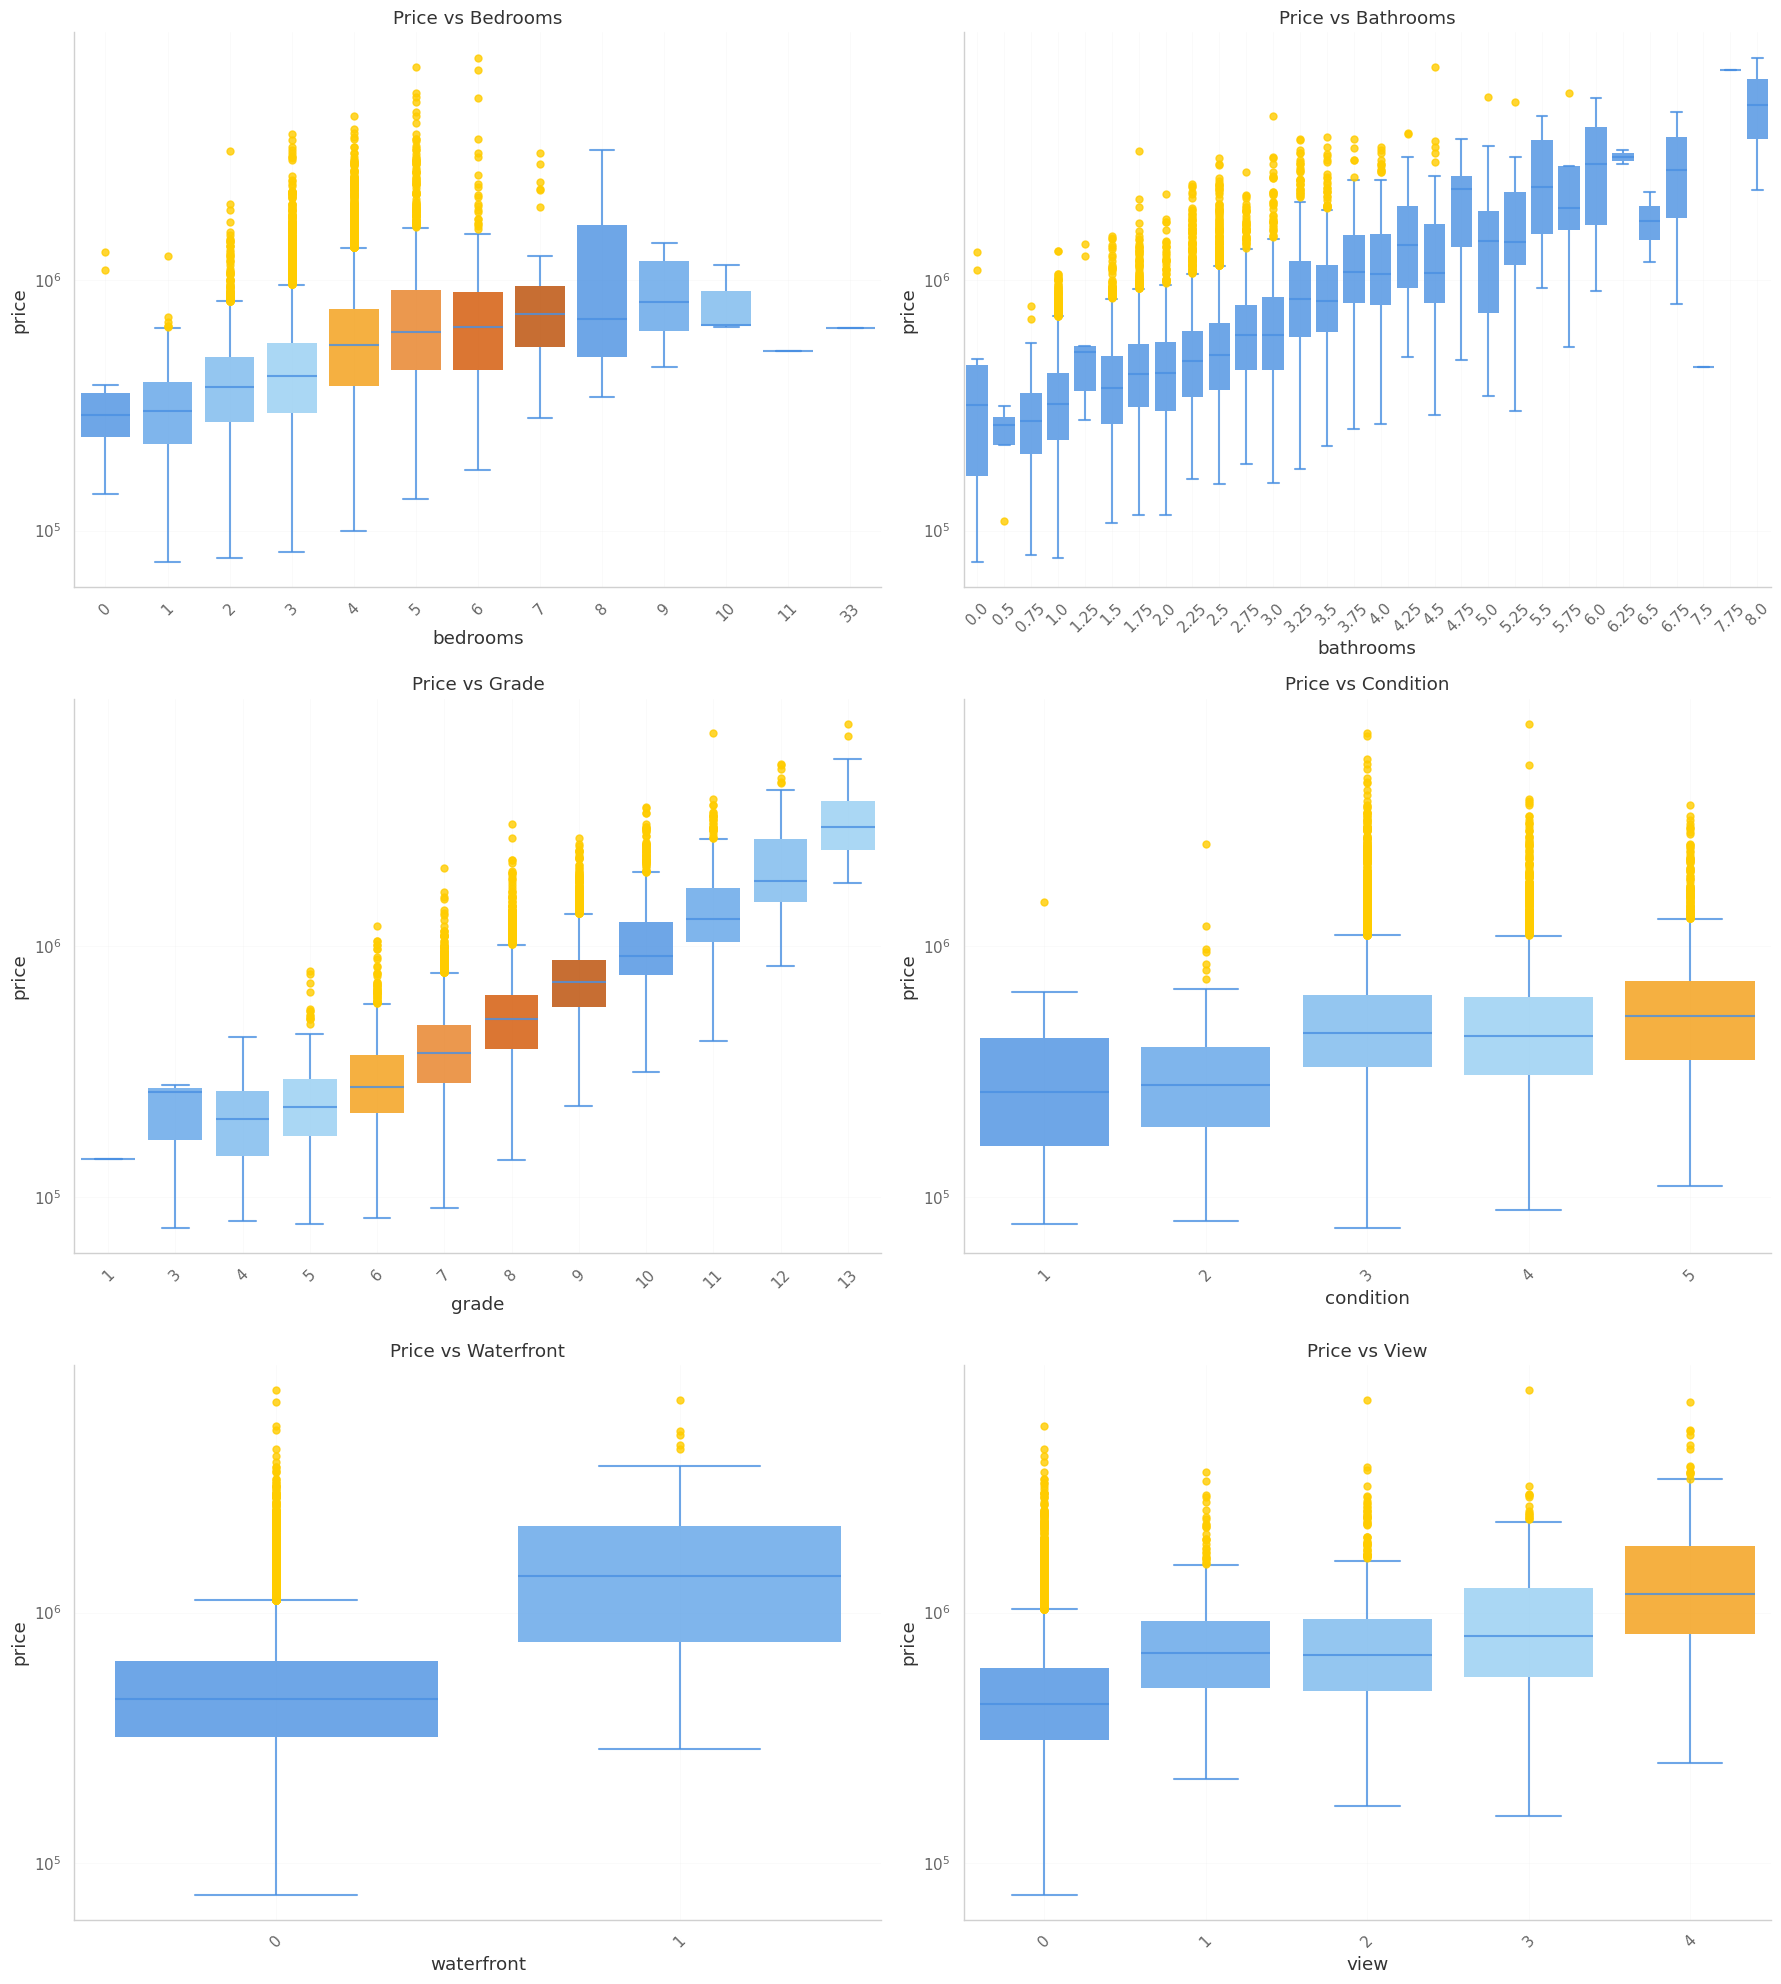

In [71]:
flier_props = dict(
    marker='o',
    markerfacecolor='#ffcc00',
    markeredgecolor='#ffcc00',
    markersize=5,
    linestyle='none'
)

cols = ["bedrooms", "bathrooms", "grade", "condition", "waterfront", "view"]
titles = [f"Price vs {c.capitalize()}" for c in cols]

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for ax, col, title in zip(axes, cols, titles):
    plt.sca(ax)  # make this axes current

    box_ax = dark_plot(
        sns.boxplot,
        data=df,
        x=col,
        y="price",
        flierprops=flier_props
    )

    box_ax.set_title(title)
    box_ax.set_yscale("log")
    box_ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()



Observations:

- `grade` increases almost monotonically with median price.
- `waterfront = 1` is associated with much higher prices.
- Higher `view` levels (3–4) also correspond to higher prices.
- `condition` appears less predictive than `grade`.

### 5.3. Zipcode vs average price

In [72]:
# Mean price by zipcode
price_by_zip = (
    df.groupby("zipcode")["price"]
      .mean()
      .sort_values(ascending=False)
)

price_by_zip.head(15)

zipcode
98039    2.160607e+06
98004    1.355927e+06
98040    1.194230e+06
98112    1.095499e+06
98102    9.012583e+05
98109    8.796236e+05
98105    8.628252e+05
98006    8.596848e+05
98119    8.494480e+05
98005    8.101649e+05
98033    8.037195e+05
98199    7.918208e+05
98075    7.905767e+05
98074    6.856058e+05
98077    6.827749e+05
Name: price, dtype: float64

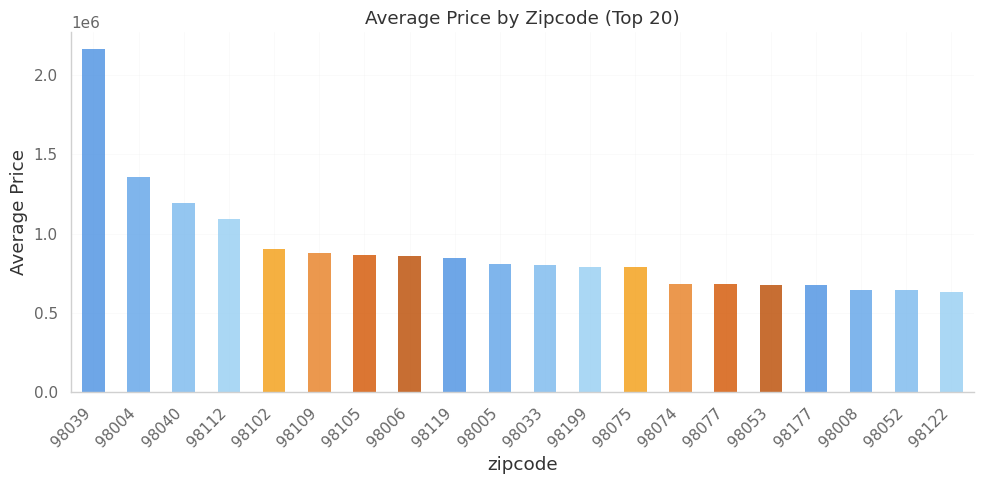

In [73]:
plt.figure(figsize=(10, 5))
price_by_zip = price_by_zip.head(20)
dark_plot(price_by_zip.plot, kind="bar")
plt.title("Average Price by Zipcode (Top 20)")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Insights:

- Some zipcodes clearly correspond to more expensive areas.
- Confirms that location is a key driver of price.

---

## 6. Correlation analysis

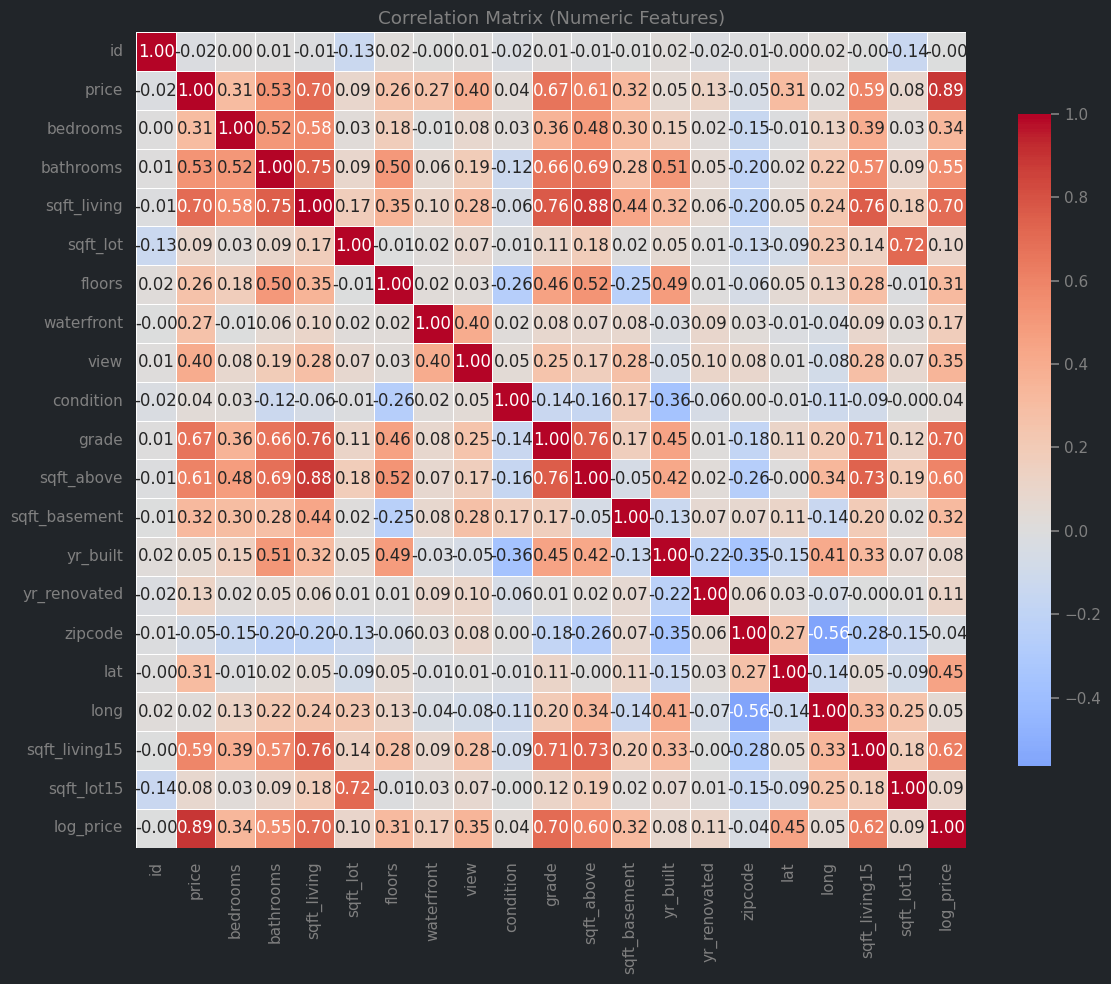

In [74]:
# Numeric columns only
num_cols_all = df.select_dtypes(include=[np.number]).columns

corr = df[num_cols_all].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()


Correlation with `price`:

In [75]:
cols_to_drop = ["id", "log_price"]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in cols_to_drop]

corr = df[num_cols].corr()
corr_price = corr["price"].sort_values(ascending=False)
corr_price

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
Name: price, dtype: float64

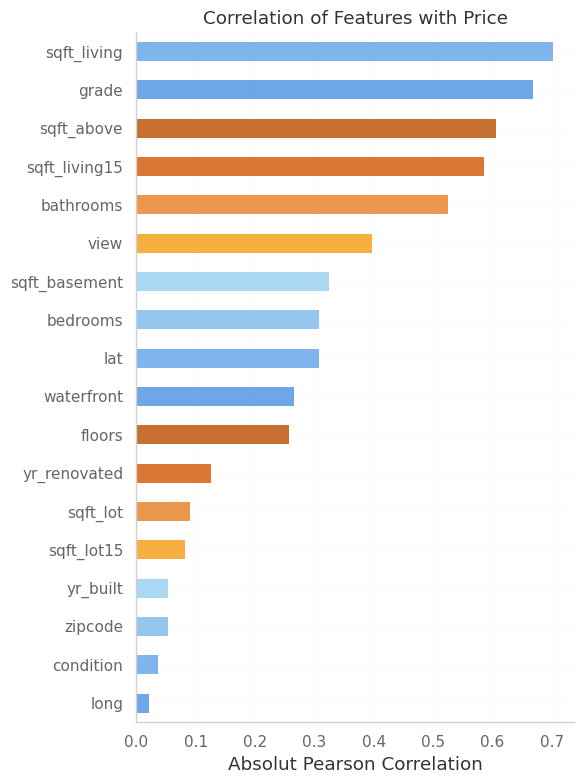

In [76]:
plt.figure(figsize=(6, 8))
ax = dark_plot(
    np.abs(corr_price).drop("price").sort_values().plot,  # corr_price equivalente
    kind="barh"
)
ax.set_title("Correlation of Features with Price")
ax.set_xlabel("Absolut Pearson Correlation")
plt.tight_layout()
plt.show()

Main insights:

- Strongest positive correlations with `price`:
  - `sqft_living`
  - `grade`
  - `sqft_above`
  - `sqft_living15`
  - `bathrooms`
  - `view`
  - `sqft_basement`
  - `lat`
  - `waterfront`
- Weak or slightly negative correlations: `zipcode`, `condition`, `yr_built`, `id`.

Check multicollinearity (high correlations between features):

In [77]:
# Pairs with high absolute correlation (e.g., > 0.8)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr_pairs = (
    upper.stack()
         .reset_index()
)

high_corr_pairs.columns = ["var1", "var2", "corr"]

high_corr_pairs[high_corr_pairs["corr"].abs() > 0.8].sort_values(by="corr", ascending=False)

,var1,var2,corr
57,sqft_living,sqft_above,0.876597


`sqft_living` strongly correlated with `sqft_above`.

---

## 7. Spatial analysis (latitude/longitude)

In [78]:
import geopandas as gpd
from shapely.geometry import Point

sample = df.sample(frac=0.5, random_state=RANDOM_STATE).copy()
sample["geometry"] = sample.apply(lambda r: Point(r["long"], r["lat"]), axis=1)
gdf = gpd.GeoDataFrame(sample, geometry="geometry", crs="EPSG:4326")
gdf_wm = gdf.to_crs(epsg=3857)


In [79]:
# ! pip install contextily

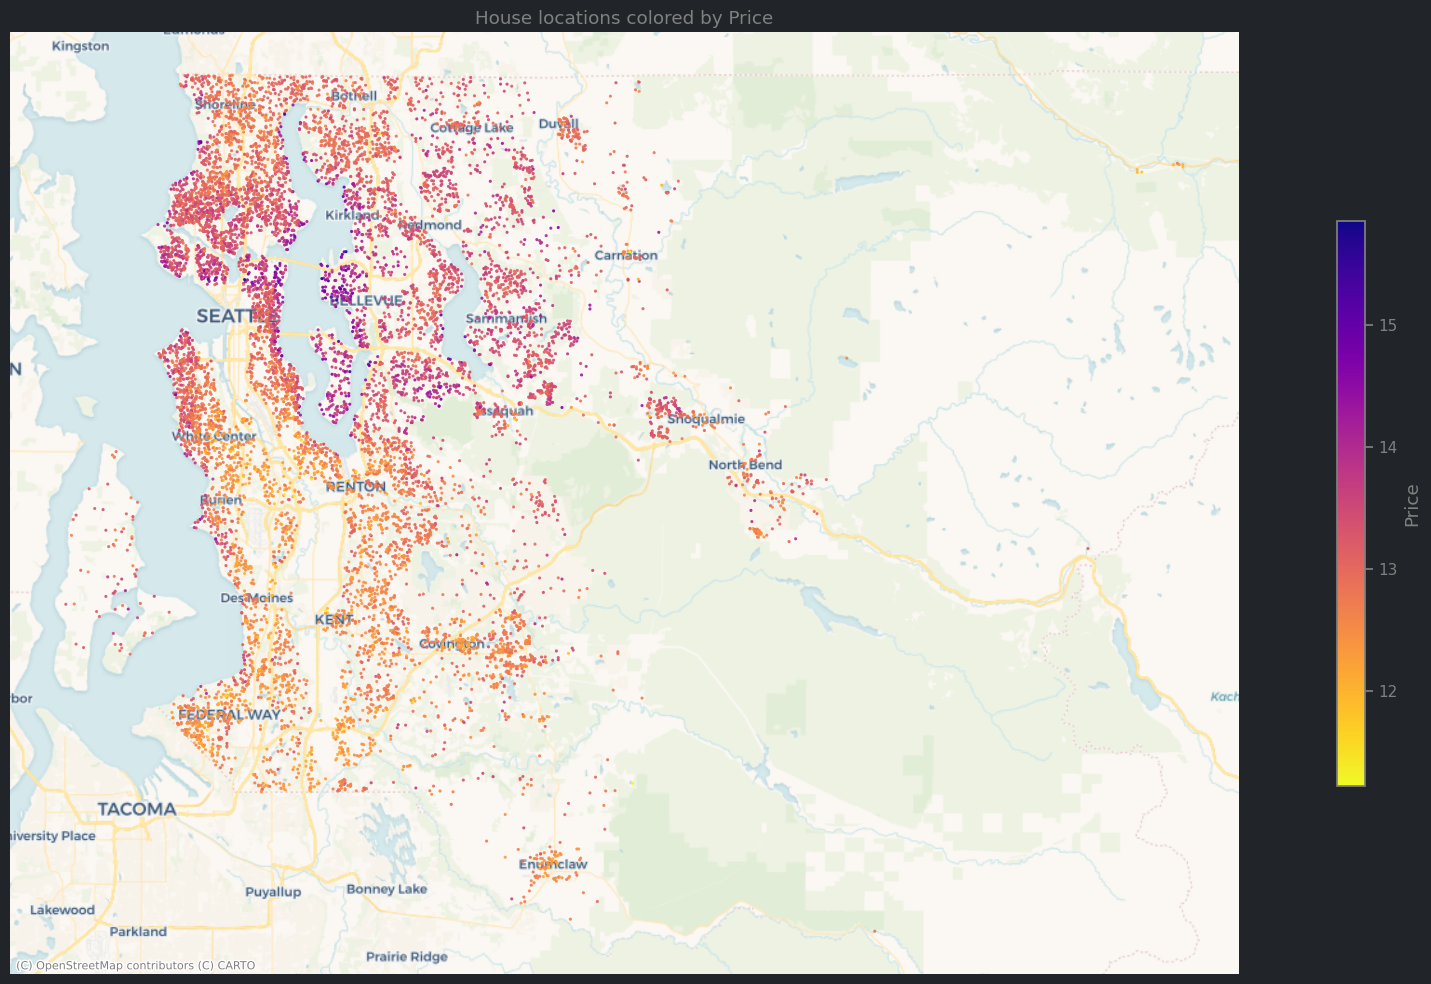

In [80]:
import contextily as cx

ax = gdf_wm.plot(
    column="log_price",
    cmap="plasma_r",
    alpha=0.9,
    markersize=5,
    legend=True,
    figsize=(20, 10),
    legend_kwds={
        "shrink": 0.6,          # < 1 encolhe a barra
        "label": "Price"
    }
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, alpha=1)
ax.set_axis_off()
plt.title("House locations colored by Price")
plt.tight_layout()
plt.show()


Observations:

- Clear clusters of high-priced homes (likely near the city center and waterfront areas).
- Confirms the strong importance of spatial features (`lat`, `long`, `zipcode`).

---

## 8. Feature engineering ideas (pre-modeling)

This section prepares transformations.

### 8.1. Date-related features

In [81]:
# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], format="%Y%m%dT%H%M%S")

# Year and month of sale
df["year_sold"] = df["date"].dt.year
df["month_sold"] = df["date"].dt.month

# House age at sale time
df["house_age"] = df["year_sold"] - df["yr_built"]

# Renovation flags and years since renovation
df["renovated"] = (df["yr_renovated"] != 0).astype(int)

df["years_since_renovation"] = np.where(
    df["yr_renovated"] == 0,
    0,
    df["year_sold"] - df["yr_renovated"]
)


df[["year_sold", "month_sold", "house_age", "renovated", "years_since_renovation"]].head()

,year_sold,month_sold,house_age,renovated,years_since_renovation
0,2014,10,59,0,0
1,2014,12,63,1,23
2,2015,2,82,0,0
3,2014,12,49,0,0
4,2015,2,28,0,0


### 8.2. Ratios and composite features

In [82]:
# Living area per bedroom

df["sqft_per_bedroom"] = np.where(
    df["bedrooms"] > 0,
    df["sqft_living"] / df["bedrooms"],
    np.nan
)

df[["sqft_per_bedroom"]].describe()

,sqft_per_bedroom
count,21600.000000
mean,618.152810
std,215.884916
min,49.090909
25%,470.000000
50%,576.666667
75%,722.500000
max,3420.000000


### 8.3. Basic outlier treatment (winsorization example)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      21613 non-null  int64         
 1   date                    21613 non-null  datetime64[ns]
 2   price                   21613 non-null  float64       
 3   bedrooms                21613 non-null  int64         
 4   bathrooms               21613 non-null  float64       
 5   sqft_living             21613 non-null  int64         
 6   sqft_lot                21613 non-null  int64         
 7   floors                  21613 non-null  float64       
 8   waterfront              21613 non-null  int64         
 9   view                    21613 non-null  int64         
 10  condition               21613 non-null  int64         
 11  grade                   21613 non-null  int64         
 12  sqft_above              21613 non-null  int64 

In [84]:
from copy import deepcopy

# Create a feature-engineered copy
df_fe = deepcopy(df)

cap_cols = ["price", "sqft_living", "sqft_lot", "sqft_living15", "sqft_lot15"]

for col in cap_cols:
    p99 = df_fe[col].quantile(0.99)
    df_fe[col] = np.where(df_fe[col] > p99, p99, df_fe[col])


df_fe[cap_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price,21613.0,532636.397446,317755.440835,75000.0,321950.0,450000.0,645000.0,1964400.0
sqft_living,21613.0,2070.087984,874.081832,290.0,1427.0,1910.0,2550.0,4978.8
sqft_lot,21613.0,13983.659140,27703.785133,520.0,5040.0,7618.0,10688.0,213008.0
sqft_living15,21613.0,1981.970620,668.390544,399.0,1490.0,1840.0,2360.0,4080.0
sqft_lot15,21613.0,12002.937445,19873.292732,651.0,5100.0,7620.0,10083.0,157687.0


### 8.4. Duplicates treatment (add a Flag colomun sold_occ)

In [85]:
# Sort by id and date to ensure chronological order
df_fe = df_fe.sort_values(['id', 'year_sold', 'month_sold'])

# Count occurrences for each house ID
df_fe['sold_occ'] = df_fe.groupby('id').cumcount() + 1

# Verify
print("Houses sold multiple times:")
print(df_fe[df_fe['sold_occ'] > 1][['id', 'year_sold','sold_occ']].head(20))

# Summary
print(f"\nTotal houses: {df_fe['id'].nunique()}")
print(f"Houses sold once: {(df_fe.groupby('id')['sold_occ'].max() == 1).sum()}")
print(f"Houses sold multiple times: {(df_fe.groupby('id')['sold_occ'].max() > 1).sum()}")
print(f"Unique values of sold_occ: {df_fe['sold_occ'].unique()}")

Houses sold multiple times:
               id  year_sold  sold_occ
2497      1000102       2015         2
16815     7200179       2015         2
11434   109200390       2014         2
12418   123039336       2014         2
7793    251300110       2015         2
9235    302000375       2015         2
14856   324000530       2015         2
7179    526059224       2015         2
17382   641900050       2015         2
19553   643300040       2015         2
15300   705730280       2015         2
9276    722039087       2015         2
3786    723049156       2014         2
824     726049190       2015         2
17603   795000620       2014         2
17604   795000620       2015         3
13693   937000330       2015         2
12066  1036400200       2015         2
11195  1139600270       2015         2
12435  1217000340       2015         2

Total houses: 21436
Houses sold once: 21260
Houses sold multiple times: 176
Unique values of sold_occ: [1 2 3]


### 8.5. Suspicious rows dropping

In [86]:
### Drop rows with "bedrooms" == 0 and "bathrooms" == 0
bed_bath0 = df_fe[(df_fe["bedrooms"] == 0) & (df_fe["bathrooms"] == 0)]
df_fe.drop(bed_bath0.index.to_list(), inplace=True)

### 8.6. Adding cluster

In [87]:
from sklearn.cluster import KMeans

kmean_king_hs = KMeans(4)
kmean_king_hs.fit(df_fe[['long','lat']])

clusters = kmean_king_hs.labels_
df_fe['loc_clusters'] = clusters ### instead of zip code

<Axes: xlabel='long', ylabel='lat'>

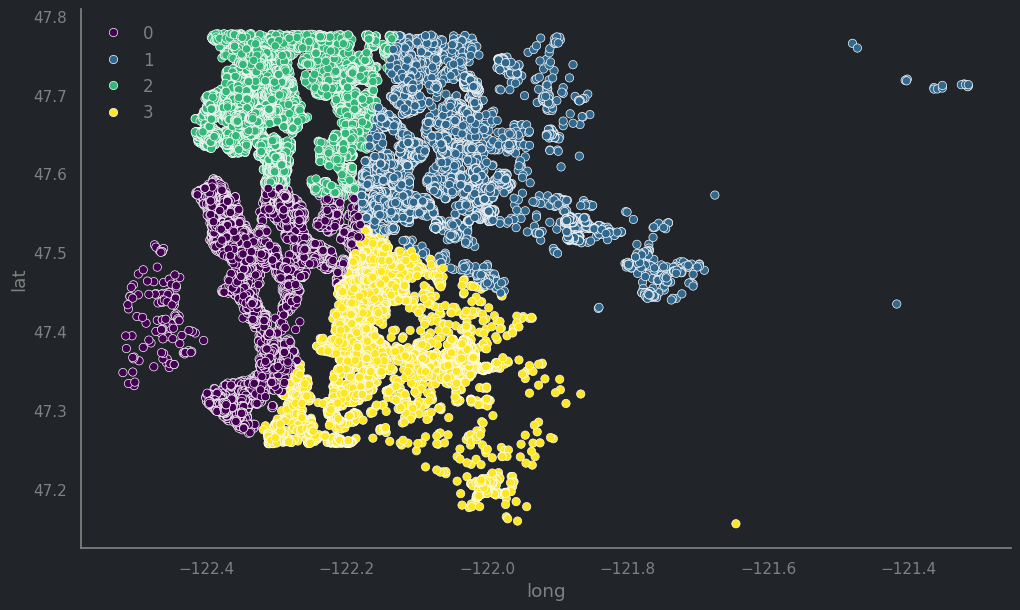

In [88]:
sns.scatterplot(x=df_fe['long'], y=df_fe['lat'], hue=clusters, palette='viridis') #, palette='viridis'

### 8.6 Grade categories

Residential Building Grades
- Grades 1 - 3 Falls short of minimum building standards. Normally cabin or inferior structure.
- Grade 4 Generally older low quality construction. Does not meet code.
- Grade 5 Lower construction costs and workmanship. Small, simple design.
- Grade 6 Lowest grade currently meeting building codes. Low quality materials, simple designs.

- Grade 7 Average grade of construction and design. Commonly seen in plats and older subdivisions.
- Grade 8 Just above average in construction and design. Usually better materials in both the exterior and interior finishes.

- Grade 9 Better architectural design, with extra exterior and interior design and quality.
- Grade 10 Homes of this quality generally have high quality features. Finish work is better, and more design quality is seen in the floor plans and larger square footage.
- Grade 11 Custom design and higher quality finish work, with added amenities of solid woods, bathroom fixtures and more luxurious options.
- Grade 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
- Grade 13 Generally custom designed and built. Approaching the Mansion level. Large amount of highest quality cabinet work, wood trim and marble; large entries.

In [89]:
df_fe.loc[df_fe.grade<=6, 'grade_clean'] = 1

df_fe.loc[df_fe.grade==7, 'grade_clean'] = 2
df_fe.loc[df_fe.grade==8, 'grade_clean'] = 2

df_fe.loc[df_fe.grade==9, 'grade_clean'] = 3
df_fe.loc[df_fe.grade==10, 'grade_clean'] = 4
df_fe.loc[df_fe.grade==11, 'grade_clean'] = 5
df_fe.loc[df_fe.grade==12, 'grade_clean'] = 6
df_fe.loc[df_fe.grade==13, 'grade_clean'] = 7

In [90]:
df_fe.grade_clean.unique()

array([2., 1., 3., 4., 5., 6., 7.])

`df_fe` can serve as a cleaned / feature-engineered version of the dataset for modeling, while preserving the original `df` for reference.


In [91]:
df_fe.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'log_price', 'year_sold',
       'month_sold', 'house_age', 'renovated', 'years_since_renovation',
       'sqft_per_bedroom', 'sold_occ', 'loc_clusters', 'grade_clean'],
      dtype='object')

In [92]:
# df_fe.to_csv("data/df_fe_EC.csv", index=False)

---

## 9. EDA summary

Main conclusions from the exploratory data analysis:

- **Data quality**:
  - No missing values across any column.
  - There are duplicated `id`s, likely representing multiple sales of the same property; this needs a modeling decision (keep latest sale only, or keep all).
  - There are strong outliers in `price`, `sqft_living`, `sqft_lot`, and a few clearly suspicious values in `bedrooms` (0 and 33 bedrooms).

- **Distributions**:
  - `price` is heavily right-skewed. A log-transform (`log_price`) produces a more symmetric distribution and is a good candidate target for linear models.
  - Typical houses have 2–4 bedrooms, 1–3 bathrooms, and 1–2 floors.

- **Relationships with price**:
  - Size (`sqft_living`, `sqft_above`), quality (`grade`), view (`view`), waterfront (`waterfront`), and location (`lat`, `long`, `zipcode`) show strong relationships with `price`.
  - `condition` appears less predictive than `grade`.

- **Correlation and multicollinearity**:
  - `sqft_living`, `sqft_above`, and `sqft_living15` are highly correlated with each other.
  - `sqft_lot` and `sqft_lot15` are also strongly correlated.
  - This suggests dropping or combining some of these for linear models to reduce multicollinearity.

- **Spatial patterns**:
  - Spatial plots of `lat`/`long` colored by price reveal clear high-price clusters (e.g., waterfront and central urban areas), reinforcing the importance of location.

- **Feature engineering proposals**:
  - Use `log_price` as the target for linear models; keep original `price` for tree-based methods if desired.
  - Create date-derived features: `year_sold`, `month_sold`, `house_age`, `renovated`, `years_since_renovation`.
  - Add density/composite features such as `sqft_per_bedroom` and `total_sqft`.
  - Apply winsorization at the 99th percentile to reduce the influence of extreme outliers.

This EDA provides a solid foundation for building and benchmarking regression models (linear, tree-based, and boosting) for house price prediction on this dataset.